#                 LETS GROW MORE - DATA SCIENCE INTERNSHIP

# TASK 2 - STOCK MARKET PREDICTION AND FORECASTING USING STACKED LSTM

### AUTHOR - Amitabh Kumar Vishwakarma

### Importing necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
url = "https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv"
dataset_train = pd.read_csv(url)
training_set = dataset_train.iloc[:, 1:2].values

In [3]:
dataset_train.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [4]:
data_close = dataset_train['Close']

In [5]:
data_close

0       233.75
1       233.25
2       234.25
3       236.10
4       233.30
         ...  
2030    118.65
2031    117.60
2032    120.65
2033    120.90
2034    121.55
Name: Close, Length: 2035, dtype: float64

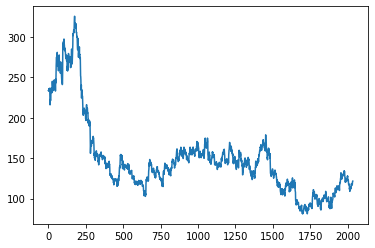

In [6]:
plt.plot(data_close)

As LSTM are sensitive to scale of data,hence we apply MinMax Scaler to transform values from 0 to 1

### Data Normalization

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range =(0,1))
data_close = scaler.fit_transform(np.array(data_close).reshape(-1,1)) 

In [8]:
data_close.shape

(2035, 1)

In [9]:
print(data_close)

[[0.62418301]
 [0.62214052]
 [0.62622549]
 ...
 [0.1621732 ]
 [0.16319444]
 [0.16584967]]


### Train And Test Split

In [11]:
training_size = int(len(data_close) * 0.75)
test_size = len(data_close) - training_size
train_data, test_data = data_close[0:training_size,:], data_close[training_size:len(data_close),:1]

In [12]:
def create_dataset(dataset, time_step = 1):
  dataX, dataY = [], []
  for i in range(len(dataset) - time_step - 1):
    a = dataset[i:(i+time_step), 0]
    dataX.append(a)
    dataY.append(dataset[i+time_step, 0])
  return np.array(dataX), np.array(dataY)

In [13]:
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [14]:
#Reshaping the input to be [features,time steps, samples] that is requirement of LSTM
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

### Creating Model

In [15]:
#Create LSTM model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer= 'adam')

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


### Training the Model 

In [17]:
model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
23/23 [==============================] - 13s 271ms/step - loss: 0.0189 - val_loss: 0.0050
Epoch 2/100
23/23 [==============================] - 5s 207ms/step - loss: 0.0021 - val_loss: 8.5756e-04
Epoch 3/100
23/23 [==============================] - 5s 205ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 4/100
23/23 [==============================] - 5s 210ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 5/100
23/23 [==============================] - 5s 205ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 6/100
23/23 [==============================] - 5s 206ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 7/100
23/23 [==============================] - 5s 204ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/100
23/23 [==============================] - 5s 208ms/step - loss: 0.0011 - val_loss: 8.6812e-04
Epoch 9/100
23/23 [==============================] - 5s 203ms/step - loss: 0.0011 - val_loss: 9.4494e-04
Epoch 10/100
23/23 [==============================] - 5s 206ms/step - loss: 0.

In [18]:
#Lets predict and check metrics of performance
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

In [19]:
#Transforming back to the original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [20]:
#Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, train_predict))

163.0008554451376

In [22]:
#Test Data RMSE
math.sqrt(mean_squared_error(y_test, test_predict))

106.33726706582483

### Plotting the model

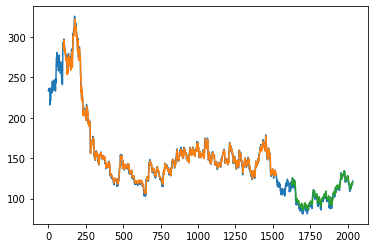

In [26]:
#Plotting

#Shift train prediction for plotting
look_back = 100
trainPredictPlot = np.empty_like(data_close)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

#Shift train prediction for plotting
testPredictPlot = np.empty_like(data_close)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2)+1:len(data_close) - 1, :] = test_predict

#Plot baseline and predictions
plt.plot(scaler.inverse_transform(data_close))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()



### Predict the next 30 days of Stock Price

In [27]:
len(test_data), x_test.shape

(509, (408, 100, 1))

In [28]:
x_input = test_data[409:].reshape(1,-1)
x_input.shape

(1, 100)

In [29]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [30]:
lst_output=[]
n_steps=100
nextNumberOfDays = 30
i=0

while(i<nextNumberOfDays):

  if(len(temp_input)>100):
    x_input=np.array(temp_input[1:])
    print("{} day input {}".format(i,x_input))
    x_input=x_input.reshape(1,-1)
    x_input = x_input.reshape((1, n_steps, 1))
    yhat = model.predict(x_input, verbose=0)
    print("{} day output {}".format(i,yhat))
    temp_input.extend(yhat[0].tolist())
    temp_input=temp_input[1:]
    lst_output.extend(yhat.tolist())
    i=i+1
  else:
    x_input = x_input.reshape((1, n_steps,1))
    yhat = model.predict(x_input, verbose=0)
    print(yhat[0])
    temp_input.extend(yhat[0].tolist())
    print(len(temp_input))
    lst_output.extend(yhat.tolist())
    i=i+1


print(lst_output)



[0.16858697]
101
1 day input [0.13848039 0.14011438 0.13888889 0.13541667 0.14011438 0.1380719
 0.13071895 0.13071895 0.12867647 0.11846405 0.14644608 0.14808007
 0.15910948 0.15992647 0.15788399 0.16441993 0.17892157 0.17933007
 0.19260621 0.20812908 0.18974673 0.18055556 0.18239379 0.17708333
 0.17810458 0.18055556 0.17810458 0.17851307 0.19607843 0.18913399
 0.18954248 0.19403595 0.19444444 0.20200163 0.19771242 0.19934641
 0.19873366 0.1997549  0.2128268  0.21568627 0.20445261 0.21772876
 0.21098856 0.21425654 0.19750817 0.18811275 0.17851307 0.17381536
 0.16033497 0.16564542 0.17116013 0.17422386 0.18035131 0.17401961
 0.16278595 0.16973039 0.17810458 0.17034314 0.16830065 0.17279412
 0.17544935 0.18382353 0.19138072 0.18913399 0.19097222 0.17238562
 0.16830065 0.1693219  0.17177288 0.16156046 0.14971405 0.1503268
 0.15196078 0.14726307 0.14501634 0.14603758 0.12479575 0.13112745
 0.11397059 0.1190768  0.12377451 0.13562092 0.12908497 0.13459967
 0.12806373 0.13031046 0.12724673 0

In [33]:
day_new = np.arange(1,101)
day_pred = np.arange(101,131)

In [34]:
df3 = data_close.tolist()
df3.extend(lst_output)

### Plot of Next 30 Days of Stock Price

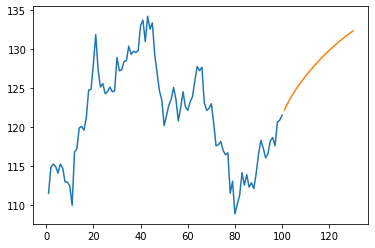

In [35]:
plt.plot(day_new, scaler.inverse_transform(data_close[1935:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))